<a href="https://colab.research.google.com/github/wsilveira-splunk/projeto_final_ciencia_dados_02_2020/blob/new_data/projeto_final_ciencia_dados_02_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo de Precificação para Geração Distribuída na Rede de Distribuição de Energia**

## Descrição:
O modelo utilizado atualmente para a Geração Distribuída (geradores instalados nas redes de distribuição) não abrange os impactos que esses geradores causam na rede, tanto os bons quanto os ruins, não diferenciando a tarifa paga por estes (todos pagam a mesma tarifa independentemente da localização). O modelo locacional é construído para capturar boa parte desses impactos e, por isso é o utilizado como exemplo a ser seguido para criar uma forma de precificação justa para a geração distribuída e para a rede.

O objetivo deste trabalho é propor um modelo de precificação para geração distribuída para o sistema de distribuição baseado no modelo existente de precificação do sistema de transmissão, especificamente utilizando o modelo da parcela locacional, utilizado no cálculo da tarifa de uso do sistema de transmissão, como referência.





Clone Git Repo if it is not already cloned.

In [2]:
%%bash

cd /content/

if [ -d "projeto_final_ciencia_dados_02_2020" ]; then
    cd projeto_final_ciencia_dados_02_2020
    git pull origin new_data
    cd -
else
  git clone https://github.com/wsilveira-splunk/projeto_final_ciencia_dados_02_2020.git
  git checkout new_data
fi

Updating 5ab4ea1..abc3ccb
Fast-forward
 .../4950_PCAT_Cemig-D_- P\303\263s Recurso.xlsx"   |   Bin 5463229 -> 0 bytes
 dados/Geradores_at_cemig.xlsx                      |   Bin 9703 -> 0 bytes
 dados/Geradores_bt_cemig1.xlsx                     |   Bin 685307 -> 0 bytes
 dados/Geradores_mt_cemig.xlsx                      |   Bin 18602 -> 0 bytes
 dados/TUST 2020/Com resultados/2020-2021.CDI       |  5229 ----
 dados/TUST 2020/Com resultados/2020-2021.CTR       |  1691 --
 dados/TUST 2020/Com resultados/2020-2021.DC        | 21477 ----------------
 dados/TUST 2020/Com resultados/2020-2021.DDC       | 20624 ---------------
 dados/TUST 2020/Com resultados/2020-2021.DES       |  1414 --
 dados/TUST 2020/Com resultados/2020-2021.DUN       | 21479 ----------------
 dados/TUST 2020/Com resultados/2020-2021.DUS       |  4304 ----
 dados/TUST 2020/Com resultados/2020-2021.GER       |  2123 --
 dados/TUST 2020/Com resultados/2020-2021.NFC       | 15456 -----------
 dados/TUST 2020/Com resultado

From https://github.com/wsilveira-splunk/projeto_final_ciencia_dados_02_2020
 * branch            new_data   -> FETCH_HEAD


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
dataset_path = r'projeto_final_ciencia_dados_02_2020/dados/projecao_precos.csv'

df = pd.read_csv(dataset_path, sep=';') 

df.head

<bound method NDFrame.head of              dia         mes  ...  carga_n  pld_medio_se 
0     17/01/2013  01/01/2013  ...     3976         339.83
1     18/01/2013  01/01/2013  ...     4016         339.83
2     19/01/2013  01/01/2013  ...     3937         479.82
3     20/01/2013  01/01/2013  ...     3750         479.82
4     21/01/2013  01/01/2013  ...     4091         479.82
...          ...         ...  ...      ...            ...
1457  13/01/2017  01/01/2017  ...     5069         101.24
1458  14/01/2017  01/01/2017  ...     4831         128.50
1459  15/01/2017  01/01/2017  ...     4670         128.50
1460  16/01/2017  01/01/2017  ...     5146         128.50
1461  17/01/2017  01/01/2017  ...     5149         128.50

[1462 rows x 23 columns]>

In [5]:
df.shape

(1462, 23)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dia                         1462 non-null   object 
 1   mes                         1462 non-null   object 
 2   armazenamento_sin           1462 non-null   float64
 3   armazenamento_se            1462 non-null   float64
 4   armazenamento_s             1462 non-null   float64
 5   armazenamento_ne            1462 non-null   float64
 6   armazenamento_n             1462 non-null   float64
 7   ena_sin                     1462 non-null   float64
 8   ena_se                      1462 non-null   float64
 9   ena_s                       1462 non-null   float64
 10  ena_ne                      1462 non-null   float64
 11  ena_n                       1462 non-null   float64
 12  expectativa_ena_7_dias_sin  1462 non-null   float64
 13  expectativa_ena_7_dias_se   1462 

In [7]:
df.describe()

armazenamento_sin  armazenamento_se  ...      carga_n  pld_medio_se 
count        1462.000000       1462.000000  ...  1462.000000    1462.000000
mean            0.407038          0.398303  ...  5095.934337     329.579439
std             0.113798          0.126739  ...   447.671479     246.537669
min             0.188954          0.151234  ...  3727.000000      30.250000
25%             0.320920          0.327357  ...  4920.250000     140.710000
50%             0.402954          0.370591  ...  5190.500000     270.230000
75%             0.486435          0.491432  ...  5374.750000     388.480000
max             0.633005          0.639768  ...  8231.000000     822.830000

[8 rows x 21 columns]

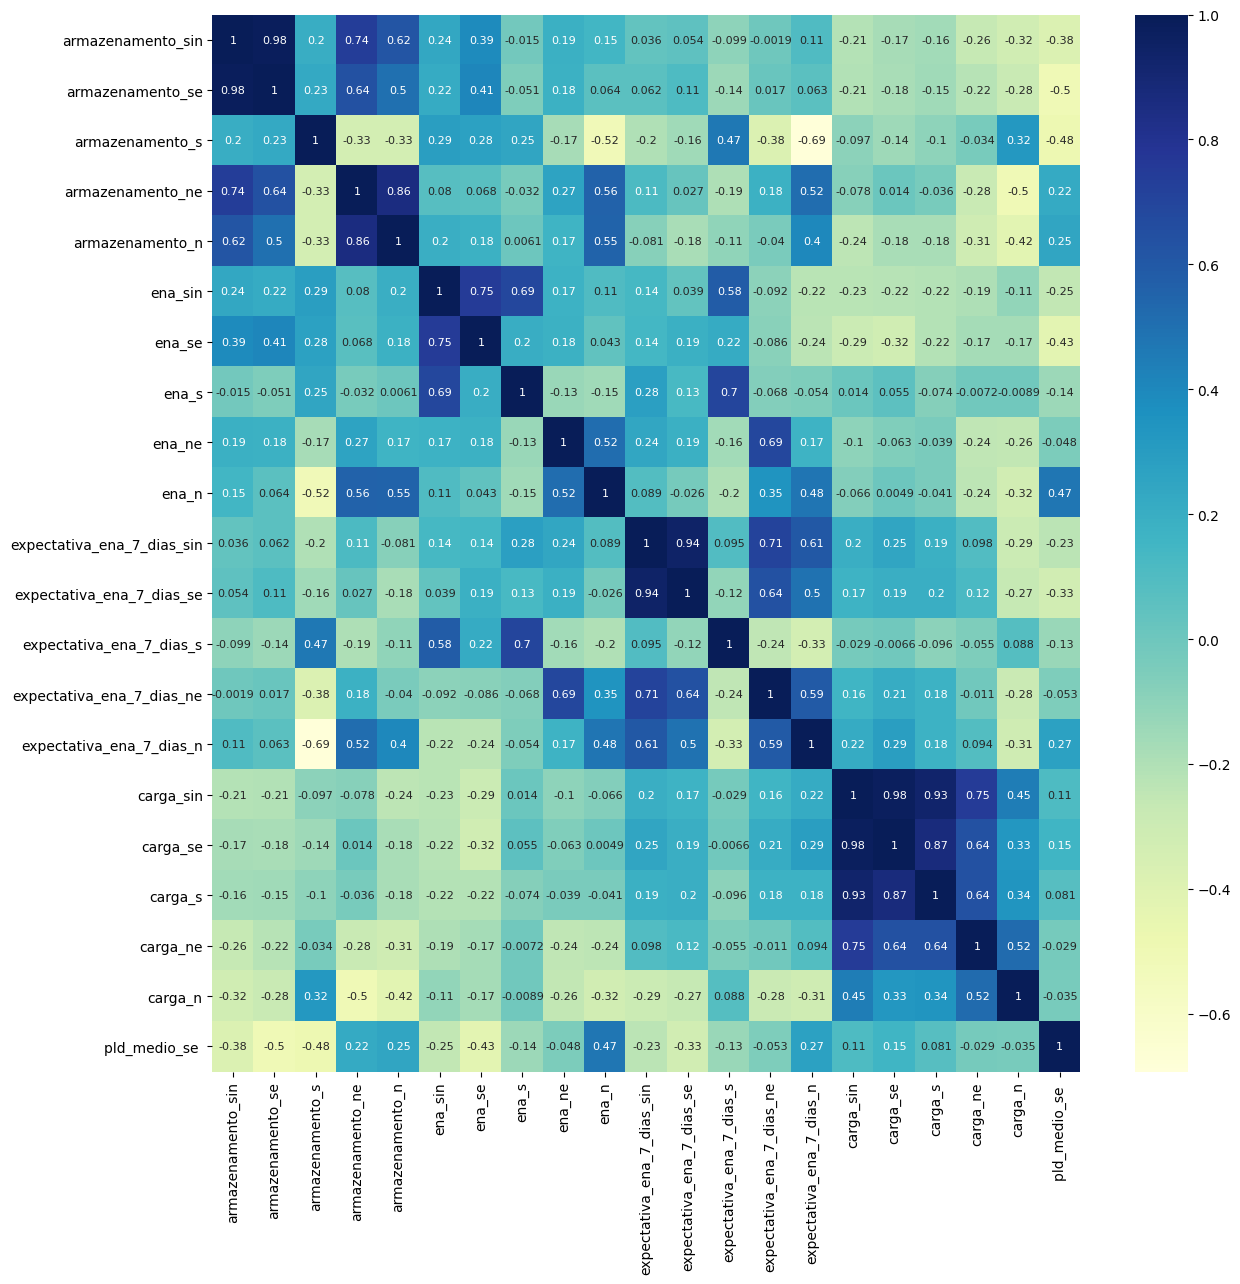

In [8]:
fig=plt.figure(figsize=(14,14), dpi= 100, facecolor='w', edgecolor='k')

sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, annot_kws={"size":8})
plt.show()

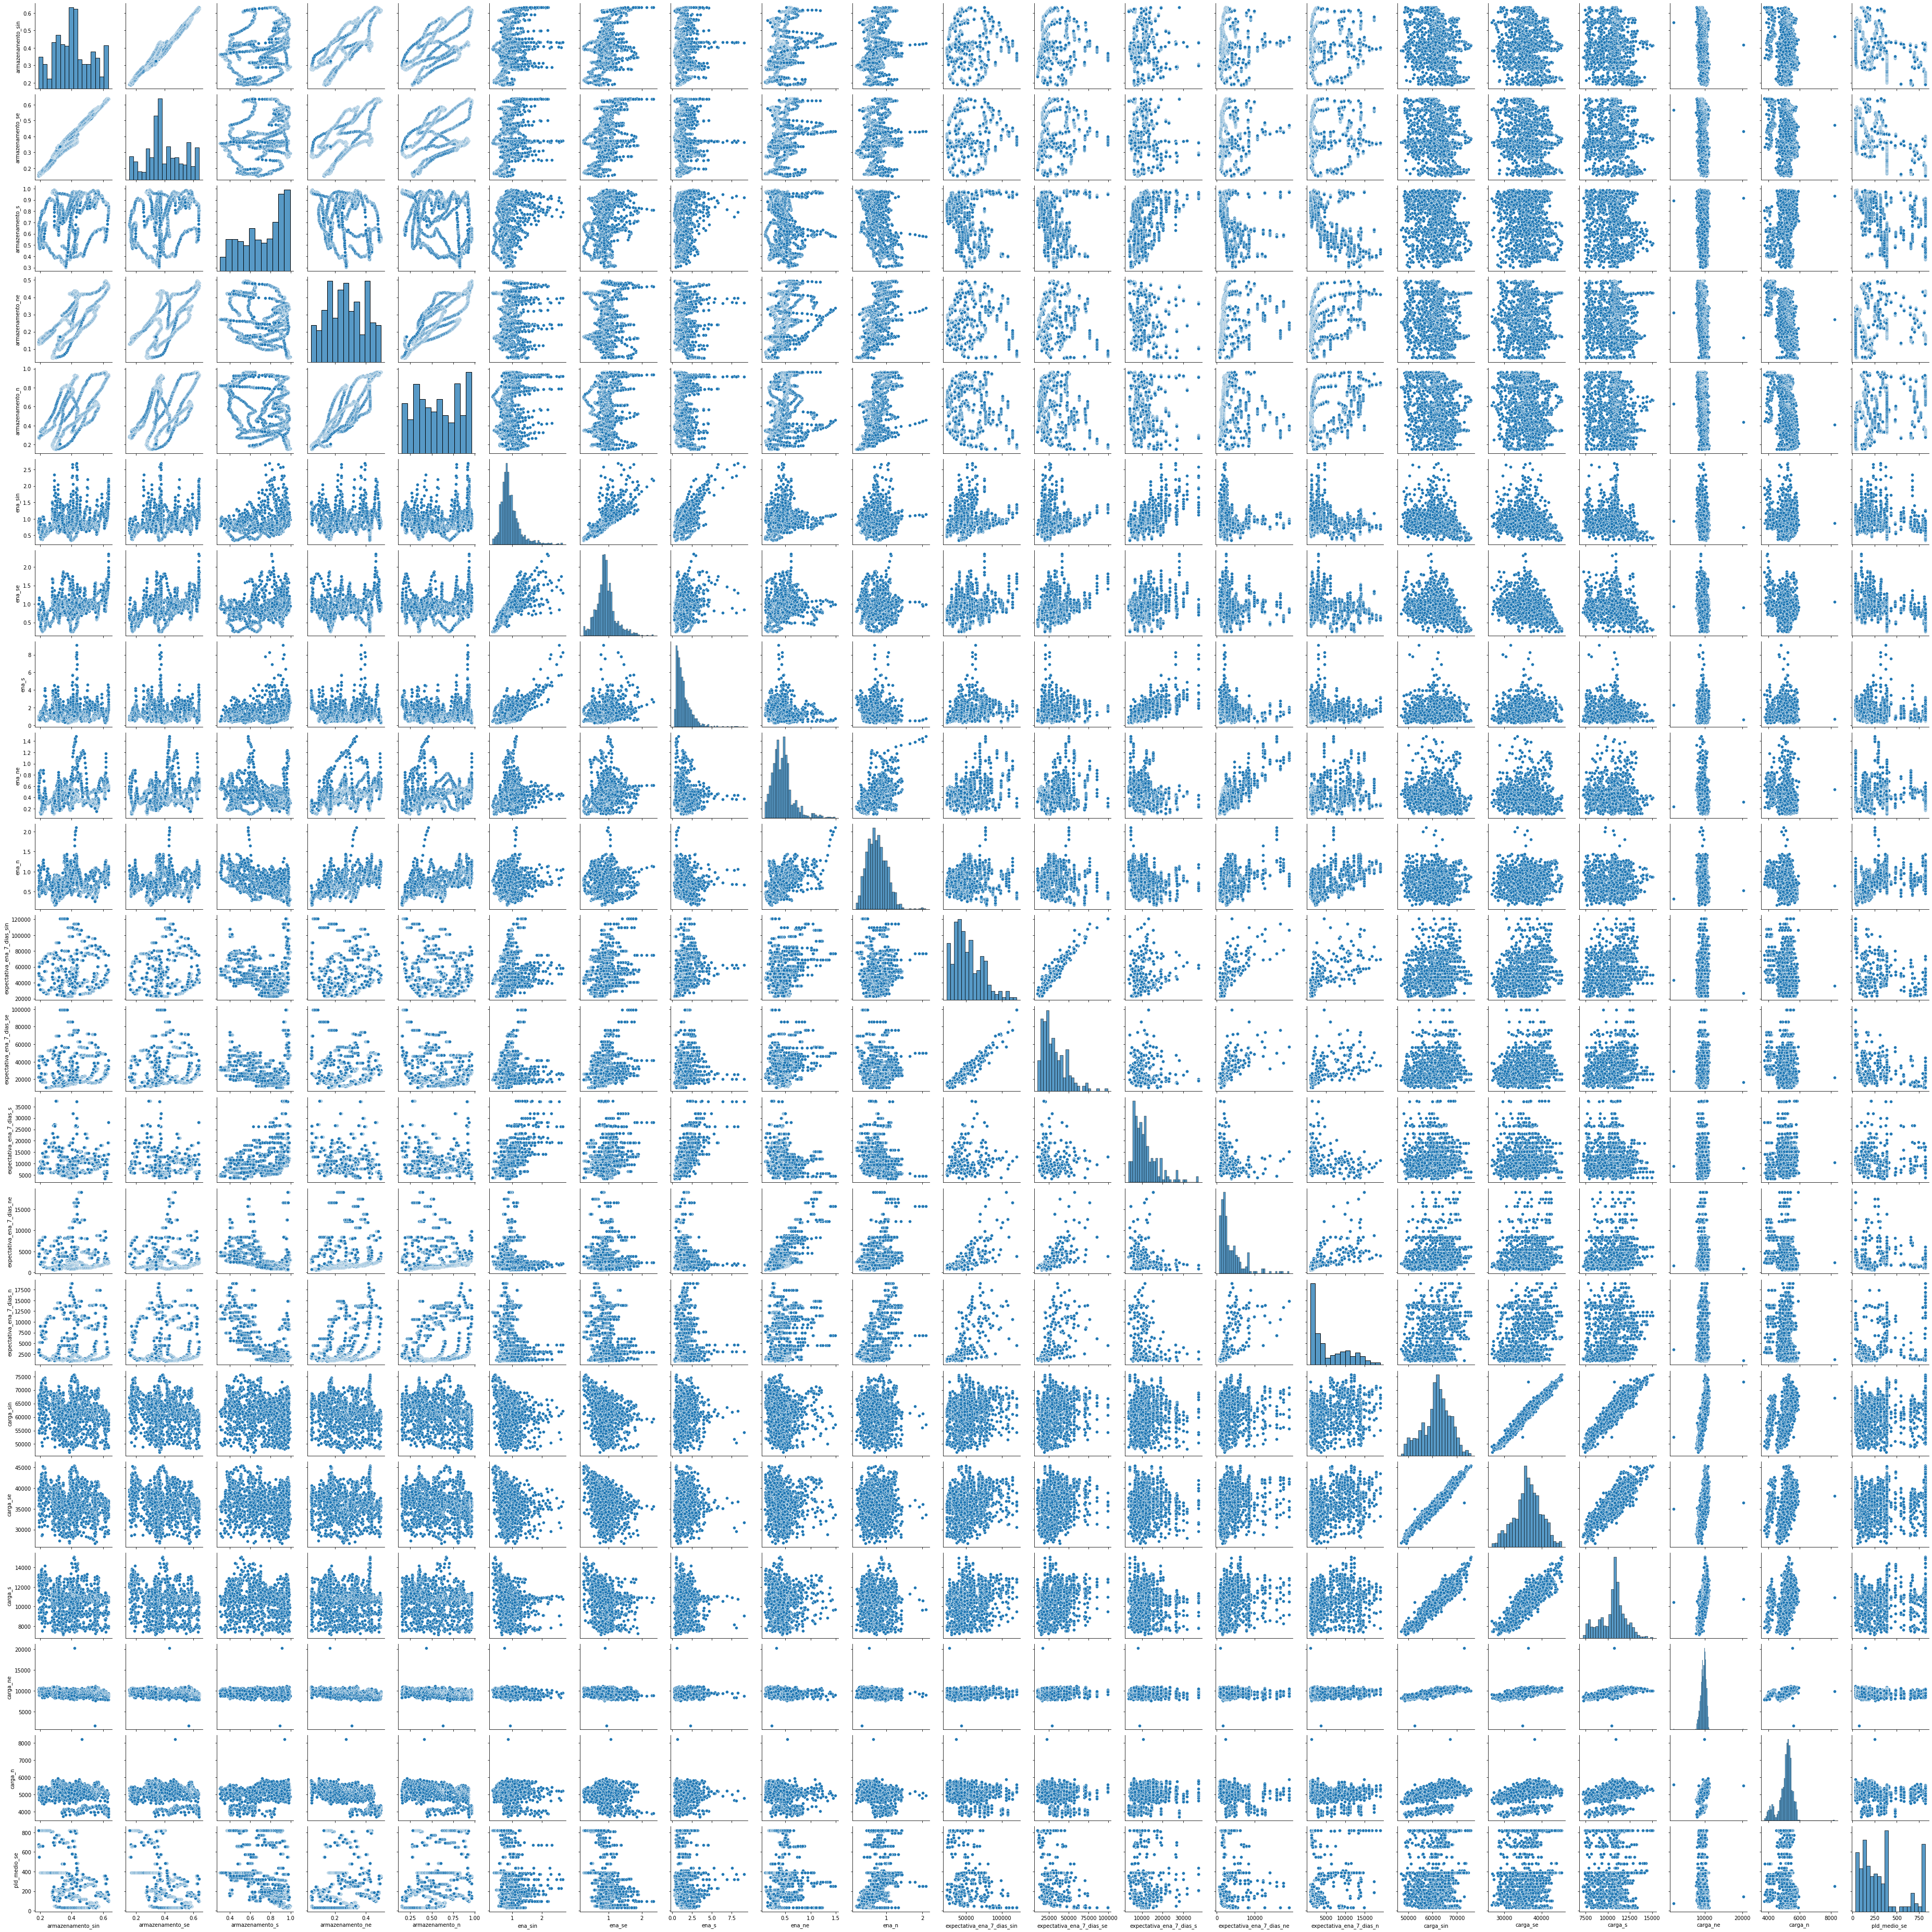

In [53]:
sns.pairplot(df)

In [8]:
df_num = df[df.columns[2:]]

np.random.seed(0)
df_train, df_test = train_test_split(df_num, train_size = 0.7, test_size = 0.3, random_state = 100)

In [9]:
scaler = MinMaxScaler()

num_vars = ['armazenamento_s', 'armazenamento_ne', 'armazenamento_n',
       'ena_sin', 'ena_se', 'ena_s', 'ena_ne', 'ena_n',
       'expectativa_ena_7_dias_sin', 'expectativa_ena_7_dias_se',
       'expectativa_ena_7_dias_s', 'expectativa_ena_7_dias_ne',
       'expectativa_ena_7_dias_n', 'carga_sin', 'carga_se', 'carga_s',
       'carga_ne', 'carga_n', 'pld_medio_se ']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


armazenamento_sin  armazenamento_se  ...   carga_n  pld_medio_se 
210            0.584177          0.584108  ...  0.344789       0.147644
318            0.400040          0.418364  ...  0.222049       0.352482
239            0.517528          0.520883  ...  0.361080       0.302783
987            0.321431          0.320737  ...  0.407721       0.222602
1417           0.310681          0.333887  ...  0.282973       0.090515
...                 ...               ...  ...       ...            ...
802            0.298028          0.282783  ...  0.357956       0.451980
53             0.477027          0.474796  ...  0.121178       0.393310
350            0.430462          0.433284  ...  0.347467       0.277158
79             0.561786          0.560820  ...  0.097300       0.200434
792            0.266184          0.249022  ...  0.289891       0.451980

[1023 rows x 21 columns]

In [10]:
y_train = df_train.pop('pld_medio_se ')
X_train = df_train

In [18]:
X_train_lr1 = sm.add_constant(X_train)

lr_1 = sm.OLS(y_train, X_train_lr1).fit()

lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pld_medio_se    R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     406.6
Date:                Tue, 08 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:36:13   Log-Likelihood:                 839.39
No. Observations:                1023   AIC:                            -1639.
Df Residuals:                    1003   BIC:                            -1540.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       3.587e+07    4.3e+06      8.333      0.000    2.74e+07    4.43e+07
armazenamento_sin             -8.1327     10.101     -0.805      0.421     -27.955      11.690
armazenamento_se               2.5486      7.086      0.360      0.719     -11.357      16.454
armazenamento_s                0.5589      0.480      1.164      0.245      -0.383       1.501
armazenamento_ne               2.2511      0.819      2.750      0.006       0.645       3.857
armazenamento_n                0.0651      0.417      0.156      0.876      -0.753       0.884
ena_sin                        0.3002      0.104      2.897      0.004       0.097       0.504
ena_se                         0.0076      0.080      0.096      0.924      -0.149       0.164
ena_s                         -0.4131      0.085     -4.875      0.000      -0.579      -0.247
ena_ne                        -0.1579      0.054     -2.937      0.003      -0.263      -0.052
ena_n                          0.1683      0.049      3.465      0.001       0.073       0.264
expectativa_ena_7_dias_sin  5.121e+08   6.15e+07      8.333      0.000    3.92e+08    6.33e+08
expectativa_ena_7_dias_se  -4.632e+08   5.56e+07     -8.333      0.000   -5.72e+08   -3.54e+08
expectativa_ena_7_dias_s   -1.784e+08   2.14e+07     -8.333      0.000    -2.2e+08   -1.36e+08
expectativa_ena_7_dias_ne  -9.617e+07   1.15e+07     -8.333      0.000   -1.19e+08   -7.35e+07
expectativa_ena_7_dias_n   -9.464e+07   1.14e+07     -8.333      0.000   -1.17e+08   -7.24e+07
carga_sin                  -6.201e+06   7.44e+05     -8.333      0.000   -7.66e+06   -4.74e+06
carga_se                    4.052e+06   4.86e+05      8.333      0.000     3.1e+06    5.01e+06
carga_s                     1.749e+06    2.1e+05      8.333      0.000    1.34e+06    2.16e+06
carga_ne                    2.079e+06    2.5e+05      8.333      0.000    1.59e+06    2.57e+06
carga_n                     9.917e+05   1.19e+05      8.333      0.000    7.58e+05    1.23e+06
==============================================================================
Omnibus:                       43.732   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.645
Skew:                          -0.471   Prob(JB):                     1.01e-11
Kurtosis:                       3.549   Cond. No.                     1.86e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.3e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [11]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 10)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('armazenamento_sin', False, 4),
 ('armazenamento_se', False, 2),
 ('armazenamento_s', False, 5),
 ('armazenamento_ne', False, 3),
 ('armazenamento_n', False, 10),
 ('ena_sin', False, 7),
 ('ena_se', False, 11),
 ('ena_s', False, 6),
 ('ena_ne', False, 9),
 ('ena_n', False, 8),
 ('expectativa_ena_7_dias_sin', True, 1),
 ('expectativa_ena_7_dias_se', True, 1),
 ('expectativa_ena_7_dias_s', True, 1),
 ('expectativa_ena_7_dias_ne', True, 1),
 ('expectativa_ena_7_dias_n', True, 1),
 ('carga_sin', True, 1),
 ('carga_se', True, 1),
 ('carga_s', True, 1),
 ('carga_ne', True, 1),
 ('carga_n', True, 1)]

In [12]:
selected_columns = ['expectativa_ena_7_dias_sin', 'expectativa_ena_7_dias_se',
       'expectativa_ena_7_dias_s', 'expectativa_ena_7_dias_ne',
       'expectativa_ena_7_dias_n', 'carga_sin', 'carga_se', 'carga_s',
       'carga_ne', 'carga_n']

X_train_rfe = X_train[selected_columns]

X_train_lm = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train, X_train_lm).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pld_medio_se    R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     76.65
Date:                Tue, 08 Dec 2020   Prob (F-statistic):          6.07e-108
Time:                        12:31:35   Log-Likelihood:                -1.6435
No. Observations:                1023   AIC:                             23.29
Df Residuals:                    1013   BIC:                             72.59
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       2.372e+07   9.35e+06      2.538      0.011    5.38e+06    4.21e+07
expectativa_ena_7_dias_sin  3.386e+08   1.33e+08      2.538      0.011    7.68e+07       6e+08
expectativa_ena_7_dias_se  -3.063e+08   1.21e+08     -2.538      0.011   -5.43e+08   -6.95e+07
expectativa_ena_7_dias_s    -1.18e+08   4.65e+07     -2.538      0.011   -2.09e+08   -2.68e+07
expectativa_ena_7_dias_ne   -6.36e+07   2.51e+07     -2.538      0.011   -1.13e+08   -1.44e+07
expectativa_ena_7_dias_n   -6.258e+07   2.47e+07     -2.538      0.011   -1.11e+08   -1.42e+07
carga_sin                    -4.1e+06   1.62e+06     -2.538      0.011   -7.27e+06    -9.3e+05
carga_se                    2.679e+06   1.06e+06      2.538      0.011    6.08e+05    4.75e+06
carga_s                     1.156e+06   4.56e+05      2.538      0.011    2.62e+05    2.05e+06
carga_ne                    1.375e+06   5.42e+05      2.538      0.011    3.12e+05    2.44e+06
carga_n                     6.558e+05   2.58e+05      2.538      0.011    1.49e+05    1.16e+06
==============================================================================
Omnibus:                       61.259   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.632
Skew:                           0.648   Prob(JB):                     2.79e-16
Kurtosis:                       2.967   Cond. No.                     9.30e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.37e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Features  VIF
0  expectativa_ena_7_dias_sin  inf
1   expectativa_ena_7_dias_se  inf
2    expectativa_ena_7_dias_s  inf
3   expectativa_ena_7_dias_ne  inf
4    expectativa_ena_7_dias_n  inf
5                   carga_sin  inf
6                    carga_se  inf
7                     carga_s  inf
8                    carga_ne  inf
9                     carga_n  inf

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

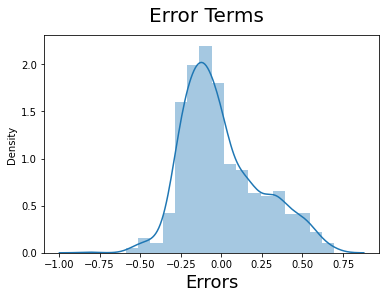

In [17]:
y_train_price = lm.predict(X_train_lm)

fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label